# Predicting Job Salary

## Introduction

It is generally conceived that the salary amount of a worker depends on job type and experience, but we would like to see if it is possible to reduce this back further to education level. The ability for someone to get a “better” job tends to depend on their education level, which is why our Data Science project question is: "Can we predict the salary of a worker depending on their education level and years of working experience in their job?”

The dataset we are using contains 7 columns reading left to right: `Education`, `Experience`, `Location`, `Job_Title`, `Age`, `Gender`, and `Salary`, where each row represents an individual worker.

- `Education`: four categories representing the highest level of education received: High School, Bachelor, Master, PhD
- `Experience`: years of professional experience
- `Location`: three locations of work: Urban, Suburban, Rural
- `Job_Title`: four general job titles: Manager, Director, Analyst, Engineer
- `Age`: age
- `Gender`: Female or Male
- `Salary`: annual salary

## Data analysis

In order to do the data analysis, we first need to download and load in our data.

In [21]:
library(tidyverse)  # Load in the library needed to read the csv file

In [1]:
# Download and load the csv file into a data frame
# Dataset website: https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data
website <- "https://raw.githubusercontent.com/WhenLifeHandsYouLemons/UBC-DSCI-100-Project/data/salary_prediction_data.csv"
download.file(website, "salary_prediction_data.csv")

df_untidy <- read_csv("salary_prediction_data.csv")

# Dataset before cleaning
head(df_untidy)

ERROR: Error in read_csv("salary_prediction_data.csv"): could not find function "read_csv"


*Table 1: Untidy data*

Looking at *Table 1*, we can see that our headers are not in a tidy format and that they include many columns that we will not be using in our model. We can tidy our dataset to only include the columns (variables) we'll use and then clean up the row data to work better with our code. We will clean it by making the variables all lowercase and using underlines instead of spaces. We will also round the `salary` column to be $2$ decimal places as it's a dollar amount and so can only be up to $2$ decimal places.

In [23]:
# Rename all the columns to include the units and be in lowercase
# Then select the newly mutated columns that we will use in our analysis only
df_tidy <- df_untidy |>
    mutate(education = Education, experience_years = Experience, salary_dollars = Salary) |>
    select(salary_dollars, education, experience_years) |>
    mutate(salary_dollars = round(salary_dollars, 2)) |>  # We round the dollars to 2 decimal places
    mutate(education = as_factor(education))  # We change the column's data type

# Create dummy variables for education levels
# This is used for predicting and then combined into one for visualisations
df_tidy$phd <- as.numeric(df_tidy$education == "PhD")
df_tidy$bachelor <- as.numeric(df_tidy$education == "Bachelor")
df_tidy$master <- as.numeric(df_tidy$education == "Master")
df_tidy$high_school <- as.numeric(df_tidy$education == "High School")

# This is the same dataset, but cleaned up
head(df_tidy)

salary_dollars,education,experience_years,phd,bachelor,master,high_school
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
84620.05,High School,8,0,0,0,1
142591.26,PhD,11,1,0,0,0
97800.26,Bachelor,28,0,1,0,0
96834.67,High School,29,0,0,0,1
132157.79,PhD,25,1,0,0,0
156312.94,PhD,19,1,0,0,0


*Table 2: Tidied data with split education levels*

In *Table 2*, we can see that we have tidied our data. We have also taken the "`Education`" column and converted it into a numerical value. We did this because we wanted to use the "`Education`" column as a predictor variable in our model and so they needed to be in numeric form. To do so, we separated the "`Education`" column into four separate columns, each representing a different education level. We then assigned a $1$ to the column that corresponds to the education level of the worker and $0$ to the other columns. This way, we were able to use the "`Education`" column as a predictor variable in our model.

Now, we can load the `tidymodels` library in order to do the regression analysis.

In [24]:
library(tidymodels)  # Load library for spliting data into training and testing
library(gridExtra)  # Load library for positioning plots side-by-side

After loading the library, we can split our entire dataset into a training and a testing split. To make it consistent each time (not be affected by randomness), we use the `set.seed()` function to make it split the same each time it's run.

Before we do the training and analysis, we should look at a section of our data and get some simple statistics from it to get an idea of how our data looks like.

In [25]:
# Set the seed for this code cell
set.seed(1)

# Split data into a rough 75-25 split
df_split <- initial_split(df_tidy, 0.75, salary_dollars)
df_training <- training(df_split)
df_testing <- testing(df_split)

# Summarise the values in each of our predictor classes
df_summary <- df_training |>
    summarise("Total observations in subsection" = length(experience_years),
              "Average experience (years)" = round(mean(experience_years, na.rm = TRUE)),
              "Average salary (dollars)" = round(mean(salary_dollars, na.rm = TRUE), 2),
              "Total high-school educations" = sum(high_school, na.rm = TRUE),
              "Total Bachelor educations" = sum(bachelor, na.rm = TRUE),
              "Total Master educations" = sum(master, na.rm = TRUE),
              "Total PhD educations" = sum(phd, na.rm = TRUE))

# The data split sizes and the summary is shown below
df_split
df_summary

<Training/Testing/Total>
<748/252/1000>

Total observations in subsection,Average experience (years),Average salary (dollars),Total high-school educations,Total Bachelor educations,Total Master educations,Total PhD educations
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
748,15,105568.6,190,184,195,179


*Table 3: Data statistics on the training data*

*Note: Our data didn't seem to have any observations with missing data (or `NA`) but we still included `na.rm=TRUE` just in case.*

There seems to be a relatively even split in the total number of people with different education levels in our training data as they are all between $179$ to $195$.

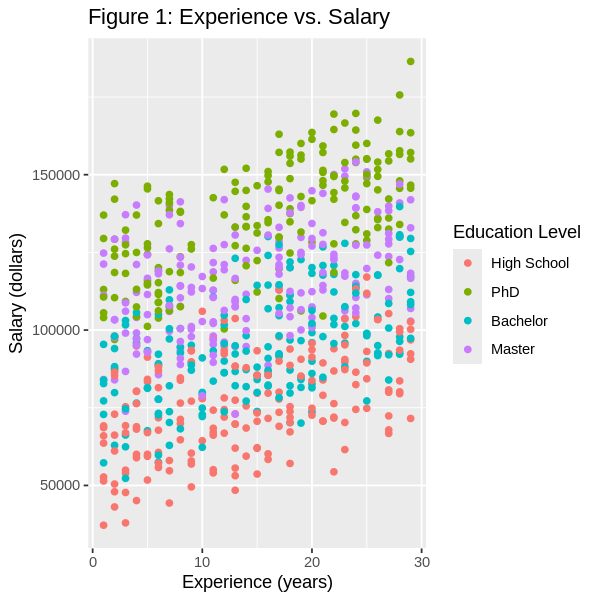

In [26]:
# Set the plot size
options(repr.plot.height = 5, repr.plot.width = 5)

# Creating a scatter plot of the testing data
train_stat_plot <- df_training |>
    ggplot(aes(x = experience_years, y = salary_dollars, color = education)) +
    geom_point() +
    ggtitle("Figure 1: Experience vs. Salary") +
    xlab("Experience (years)") +
    ylab("Salary (dollars)") +
    labs(color = "Education Level")

# Display the plot
train_stat_plot

We can see from *Figure 1* that there seems to be some relationship between the salary of workers and their years of experience. We also seem to see a very small relationship between the salary of workers and their education level as the PhD data points are higher up than the high school in general.

Now that we've looked at our data and some simple statistics and visualisations of it, we can move on to creating our regression model:

In [27]:
# Train the linear regression model on all the predictors (education levels and experience) using the training data split
reg_model <- lm(salary_dollars ~ experience_years + phd + bachelor + master, data = df_training)

# Summarize the regression results
summary(reg_model)


Call:
lm(formula = salary_dollars ~ experience_years + phd + bachelor + 
    master, data = df_training)

Residuals:
   Min     1Q Median     3Q    Max 
-41100 -11379   -259  10364  36197 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      60926.43    1396.04   43.64   <2e-16 ***
experience_years  1110.73      64.03   17.35   <2e-16 ***
phd              58151.73    1522.97   38.18   <2e-16 ***
bachelor         16662.63    1512.14   11.02   <2e-16 ***
master           38668.67    1488.77   25.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14600 on 743 degrees of freedom
Multiple R-squared:  0.7322,	Adjusted R-squared:  0.7307 
F-statistic: 507.8 on 4 and 743 DF,  p-value: < 2.2e-16


Looking at the summary of the regression model we trained on the training split, we can see that the `Adjusted R-squared` value seems to be $0.7307$. This suggests a decently good fit of our model to the training data as the higher the value of $R^2$, the better our model will be at predicting new values.

In our regression model, we don't include the `high_school` predictor due to multicollinearity and dummy variable trap however it is still part of our predictions.

In [28]:
# Make predictions using the new data (df_testing), then rename and combine it with the df_testing data-frame
predictions <- predict(reg_model, newdata = df_testing) |>
    as.data.frame() |>
    mutate(salary_pred = predict(reg_model, newdata = df_testing)) |>  # We use the `newdata` parameter instead of `data` for regression
    select(salary_pred) |>
    bind_cols(df_testing)

# Displaying the top few predictions and original data
head(predictions)

,salary_pred,salary_dollars,education,experience_years,phd,bachelor,master,high_school
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,146846.36,132157.79,PhD,25,1,0,0,0
2,123521.07,130567.65,PhD,4,1,0,0,0
3,133517.62,148707.74,PhD,13,1,0,0,0
4,100705.83,124251.99,Master,1,0,0,1,0
5,92026.81,81007.20,High School,28,0,0,0,1
6,65369.35,60693.92,High School,4,0,0,0,1


*Table 4: Regression model predictions on testing data*

Looking at *Table 4*, we can see that our model has predicted the salaries of the workers in the testing data. We can see that the predicted salaries seem to be in the same order of magnitude as the actual salaries of the workers. It also seems to be very close to the true values. This is promising as it suggests that our model is able to predict the salaries of workers based on their education level and years of experience. Now, we have to recombine the `phd`, `bachelor`, `master`, and `high_school` columns into the `education_level` column to then plot the data properly.

In [29]:
# We renumber and combine the different education levels to make visualisations simpler
predictions$high_school[predictions$high_school == 1] <- 1
predictions$bachelor[predictions$bachelor == 1] <- 2
predictions$master[predictions$master == 1] <- 3
predictions$phd[predictions$phd == 1] <- 4

# This works because each row only has one column with a non-zero value
predictions$education_level <- pmax(predictions$phd, predictions$bachelor, predictions$master, predictions$high_school, na.rm = TRUE)

# We can now only use the education levels as numbers instead of them being separate
predictions <- select(predictions, salary_pred, salary_dollars, education_level, education, experience_years)

# Display the top few newly cleaned up predictions and original data
head(predictions)

,salary_pred,salary_dollars,education_level,education,experience_years
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,146846.36,132157.79,4,PhD,25
2,123521.07,130567.65,4,PhD,4
3,133517.62,148707.74,4,PhD,13
4,100705.83,124251.99,3,Master,1
5,92026.81,81007.20,1,High School,28
6,65369.35,60693.92,1,High School,4


*Table 5: Regression model predictions on testing data with clean education level data*

With the predictions and the original data in a single data-frame (*Table 5*), we're now able to plot the predictions and variables visually to see any relationships between the variables and the predictor. Using the new data-frame (*Table 5*) where the `education_level` is an integer range, it helps us more easily visualise any patterns and relationships in our data. It can also potentially show us any interesting details about the data.

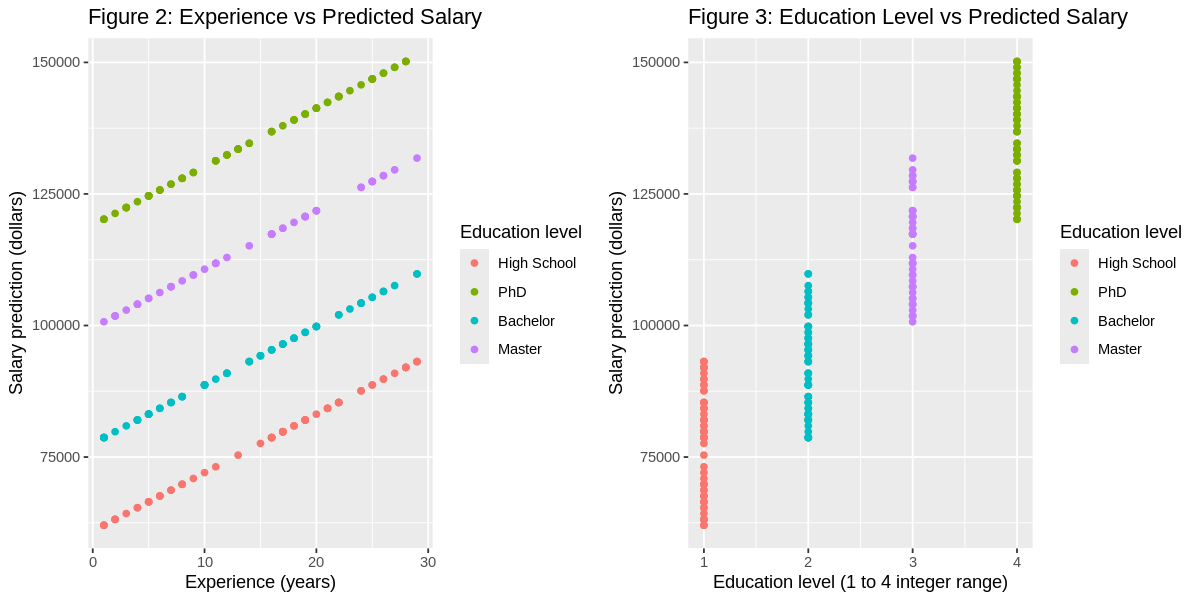

In [30]:
# Set the plot size
options(repr.plot.height = 5, repr.plot.width = 10)

exp_pred_plot <- predictions |>
    ggplot(aes(x = experience_years, y = salary_pred, color = education)) +
        geom_point() +
        ggtitle("Figure 2: Experience vs Predicted Salary") +
        xlab("Experience (years)") +
        ylab("Salary prediction (dollars)") +
        labs(color = "Education level")

edu_pred_plot <- predictions |>
    ggplot(aes(x = education_level, y = salary_pred, color = education)) +
        geom_point() +
        ggtitle("Figure 3: Education Level vs Predicted Salary") +
        xlab("Education level (1 to 4 integer range)") +
        ylab("Salary prediction (dollars)") +
        labs(color = "Education level") +
        xlim(1, 4)  # We only have 4 levels of education so we restrict the plot to that area

# View plots side-by-side
grid.arrange(exp_pred_plot, edu_pred_plot, ncol = 2)

*Note: As the relationship is technically a 3D one, we have to plot it in two separate plots as it would be difficult to visualise it and see any patterns in 3D.*

There definitely seems to be a relationship between years of experience and education level to salary. We can see that the salary of workers seems to increase with their years of experience and education level in both *Figure 2* and *Figure 3*. It looks like a worker with a low education level but with high experience can get a salary equal to or higher than a worker with a higher education level but lower experience. This is interesting as it suggests that experience can be just as important as education level in determining the salary of a worker.

## Discussion

### Expected findings

The results are about what we expected to find. The higher the education level of an individual, the greater the range of salary they are predicted to have. Salary ranges increase going from high school to Bachelor, to Master, to PhD. The same trend is seen already in employability, where people with higher degrees earned in post-secondary education find it easier to attain a job. Statistics in Canada from 2007 describe a $75.5\%$ employment rate for high school graduates and an $83.2\%$ employment rate for university graduates. Employability is also a factor in job prospects, so seeing it have a positive relationship with higher degrees of education tell us that our salary range predictions make sense.

### Impacts

As seen from the results on the graphs, there is a trend where the people with higher academic achievements typically earn a larger salary, increasing more if they also have decades of work experience. With this information, students coming out of high school, unsure whether or not they should go into post-secondary, can reference this report to see if it is worth the investment. This is especially true if their family is experiencing financial difficulties and cannot afford to send their children to college or university. It helps people make more informed decisions on how high they would like to go in their education to reach their desired salary. They could either stay at a lower level and focus on gaining more experience to earn higher pay (Gao, 2024), or increase their potential salary by spending extra effort and time by achieving a master’s or a PhD.

### Future Questions

Future questions and unanswered questions are divided into two subsets. 

1. First, further questions given our existing data include:

    **Effect of Additional Variables:** How would including other variables from the dataset, such as job title and geographic location affect the accuracy of the salary predictions? This is interesting to explore, since the relationship might differ across job titles and locations as well and our regression does not control for those differences. Adding these variables as controls to our regression would complicate our research, but could strengthen our overall model in terms of robustness. 

    **Interaction Effects:** Variables could also interact with each other. So we could question, are there interaction effects between education level and years of working experience that could further refine the salary predictions? For example, does the impact of a Master's degree on salary differ depending on the number of years of experience?

2. Second, further questions or scope for further development with more data include:

    **Long-Term Salary Trends:** How do these results change in the long-term? Is there a point where the salary growth plateaus for individuals with higher education levels? To that end, it could even be explored how economic factors, such as inflation or economic growth, impact the relationship between education level, experience, and salary over time? 

    **Comparative Analysis:** How do the salary predictions based on education level and experience compare to predictions based on other factors, such as job performance evaluations or industry certifications?

    **Regional Variations:** Do the trends observed in this study hold true across different regions or countries? Are there regional factors that significantly influence the relationship between education and salary? If so, what is the return on investment for individuals pursuing higher education in terms of increased earning potential compared to the cost of their education?

While we would need a larger dataset, or merge other data tables to perform research on most of these topics mentioned above, these topics give examples of how there is further scope for delving deeper into exploring this relationship and topic. 

## References

Gao, H. (2024). *Research on the Effect of Age and Experience on Salary based on Linear Regression and Tree-Based Train.* Highlights in Business, Economics and Management, 24, 1401-1407. https://doi.org/10.54097/2xjwsv42

Johnson, C.B., Riggs, M.L. & Downey, R.G (1987). *Fun with numbers: Alternative models for predicting salary levels.* Res High Educ, 27, 349–362. https://doi.org/10.1007/BF00991663

MrSimple. (2024). *Salary Prediction Data.* Kaggle. https://www.kaggle.com/datasets/mrsimple07/salary-prediction-data/data

Statistics Canada. (2015, November 30). *Employment rates, by educational attainment.* Statistics Canada. https://www150.statcan.gc.ca/n1/pub/71-222-x/2008001/sectionf/f-education-eng.htm
